In [1]:
path_data = 'data/'

In [2]:
from catboost import CatBoostClassifier, Pool
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import wasserstein_distance


%matplotlib inline

In [3]:
with open(path_data + 'train_random_split.pkl', 'rb') as f:
    train = pkl.load(f)
    
with open(path_data + 'valid_random_split.pkl', 'rb') as f:
    valid = pkl.load(f)
    
with open(path_data + 'test_random_split.pkl', 'rb') as f:
    test = pkl.load(f)


In [4]:
clf = CatBoostClassifier().load_model('models/model_random_split')

In [5]:
num_features = [
    'caseData_life_BLOOD_PRESSURE_SYSTOLIC',
    'caseData_life_BLOOD_PRESSURE_DIASTOLIC',
 'caseData_life_AGE',
 'caseData_life_BMI',
 'caseData_life_WEIGHT',
 'caseData_life_HEIGHT',
 'caseData_life_TOTAL_CUMULATED_SUM_DC_PTIA_ACC',
 'caseData_life_TOTAL_CUMULATED_SUM_DC_PTIA_AM',
 'caseData_life_TOTAL_CUMULATED_SUM_IT_ACC',
 'caseData_life_TOTAL_CUMULATED_SUM_IT_AM',
 'ratio_poids_taille',
 'non_all_questions']

cat_features = ['caseData_case_CLIENT_PROCESS',
 'caseData_case_PRODUCT_NAME',
 'caseData_case_CHANNEL',
 'caseData_life_GENDER',
 'caseData_life_TITLE',
 'caseData_life_SMOKED_BQ',
 'caseData_case_INSTITUTION_CODE',
 'caseData_EQUIPMENT_CONTRACT0_OTHER_CONTRACT_RISK_NAME',
 'caseData_EQUIPMENT_CONTRACT0_NAME',
 'caseData_EQUIPMENT_CONTRACT0_OTHER_CONTRACT_CAUSE',
 'caseData_EQUIPMENT_CONTRACT0_OTHER_CONTRACT_RISK_TYPE',
 'caseData_EQUIPMENT_CONTRACT0_OTHER_CONTRACT_STATUS',
 'caseData_EQUIPMENT_CONTRACT0_OTHER_CONTRACT_STATUS_TITLE',
 'caseData_life_RISK_TYPES',
 'caseData_life_UNDERWRITING_APPLICATION',
 'caseData_case_CERAMIKPRO_FRUCTIPRO',
 'caseData_life_aggDC_PTIA_CAUSE',
 'caseData_life_aggDC_PTIA_RISK_NAME',
 'caseData_life_BLOOD_PRESSURE',
 'caseData_life_UNDER_TREATMENT',
 'underwriting_life_unansweredQuestions',
 'caseData_case_INSTITUTION',
 'Q_PY_BQ1_',
 'Q_PY_BQ2_',
 'Q_PY_BQ3_',
 'Q_PY_BQ4_',
 'Q_ADD_MED_INFO_BQ1_',
 'Q_ADD_MED_INFO_BQ2_',
 'Q_ADD_INFO_MED_BQ3_',
 'Q_ADD_INFO_MED_BQ4_',
 'Q_OVER10Y_SEC1_BQ1_',
 'Q_OVER10Y_SEC1_BQ2_',
 'Q_OVER10Y_SEC1_BQ3_',
 'Q_OVER10Y_SEC1_BQ4_',
 'Q_OVER10Y_SEC1_BQ5_',
 'Q_OVER10Y_SEC2BQ1_',
 'Q_OVER10Y_SEC2BQ2_',
 'Q_OVER10Y_SEC2BQ3_',
 'Q_OVER10Y_SEC2BQ4_',
 'Q_OVER10Y_SEC2BQ5_',
 'Q_OVER10Y_SEC2BQ6_',
 'Q_OVER10Y_SEC2BQ7_',
 'Q_OVER10Y_SEC2BQ8_',
 'Q_OVER10Y_SEC2BQ9_',
 'Q_OVER10Y_SEC2BQ10_']

nlp_te_FEATURES = ['concat_question_sup_1years_nlp_te_acc',
 'concat_question_sup_1years_nlp_te_ref',
 'concat_question_sup_1years_nlp_te_cs',
 'concat_question_sup_add_info_nlp_te_acc',
 'concat_question_sup_add_info_nlp_te_ref',
 'concat_question_sup_add_info_nlp_te_cs',
 'concat_question_sup_10years_nlp_te_acc',
 'concat_question_sup_10years_nlp_te_ref',
 'concat_question_sup_10years_nlp_te_cs']

In [6]:
test.shape

(9061, 66)

In [7]:
preds_test = clf.predict(Pool(test[num_features + cat_features + nlp_te_FEATURES], cat_features=cat_features),
            prediction_type='RawFormulaVal')

preds_valid = clf.predict(Pool(valid[num_features + cat_features + nlp_te_FEATURES], cat_features=cat_features),
            prediction_type='RawFormulaVal')

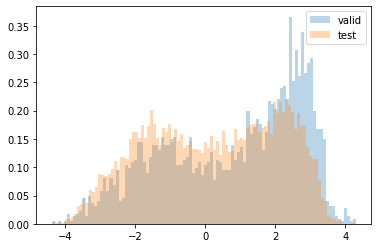

In [8]:
plt.hist(preds_valid[:, 0], bins=100, density=True, alpha=0.3)
plt.hist(preds_test[:, 0], bins=100, density=True, alpha=0.3)
plt.legend(['valid', 'test'])
plt.show()

In [9]:
wasserstein_distance(preds_test[:, 0], preds_valid[:, 0])

0.5752393825320847

In [10]:
def compute_probs(data, n=10): 
    h, e = np.histogram(data, n)
    p = h/data.shape[0]
    return e, p

def support_intersection(p, q): 
    sup_int = (
        list(
            filter(
                lambda x: (x[0]!=0) & (x[1]!=0), zip(p, q)
            )
        )
    )
    return sup_int

def get_probs(list_of_tuples): 
    p = np.array([p[0] for p in list_of_tuples])
    q = np.array([p[1] for p in list_of_tuples])
    return p, q

def kl_divergence(p, q): 
    return np.sum(p*np.log(p/q))

def js_divergence(p, q):
    m = (1./2.)*(p + q)
    return (1./2.)*kl_divergence(p, m) + (1./2.)*kl_divergence(q, m)

def compute_kl_divergence(train_sample, test_sample, n_bins=10): 
    """
    Computes the KL Divergence using the support 
    intersection between two different samples
    """
    e, p = compute_probs(train_sample, n=n_bins)
    _, q = compute_probs(test_sample, n=e)

    list_of_tuples = support_intersection(p, q)
    p, q = get_probs(list_of_tuples)
    
    return kl_divergence(p, q)

def compute_js_divergence(train_sample, test_sample, n_bins=10): 
    """
    Computes the JS Divergence using the support 
    intersection between two different samples
    """
    e, p = compute_probs(train_sample, n=n_bins)
    _, q = compute_probs(test_sample, n=e)
    
    list_of_tuples = support_intersection(p,q)
    p, q = get_probs(list_of_tuples)
    
    return js_divergence(p, q)

In [11]:
compute_kl_divergence(preds_test[:, 0], preds_valid[:, 0])

0.05711566069485982

In [12]:
compute_kl_divergence(preds_valid[:, 0], preds_test[:, 0])

0.06422374089600394

In [26]:
np.array([True, False, False]).any()

True

N124FV    1404
N124FY     562
N124FZ     278
N124AB     170
N124GF      60
N124GG      27
N124CV      18
N124HO       8
N124EI       7
N124SH       5
N124AE       4
N124PR       3
N124GD       1
N124HD       1
N124AK       1
Name: caseData_case_PRODUCT_NAME, dtype: int64

In [39]:
a = np.unique(valid['caseData_case_CLIENT_PROCESS'])

In [40]:
a.tolist()

['DIGITAL', 'PAPIER']

In [43]:
- valid['Q_ADD_MED_INFO_BQ1_'].value_counts(normalize=True)

Non   -0.9643
Oui   -0.0357
Name: Q_ADD_MED_INFO_BQ1_, dtype: float64

In [42]:
abs(- valid['Q_ADD_MED_INFO_BQ1_'].value_counts(normalize=True))

Non    0.9643
Oui    0.0357
Name: Q_ADD_MED_INFO_BQ1_, dtype: float64

In [43]:

def compute_distribution_cat(a1: np.array, a2: np.array, sample_weights1=None, sample_weights2=None):
    if sample_weights1 is None:
        sample_weights1 = np.ones_like(a1)
    if sample_weights2 is None:
        sample_weights2 = np.ones_like(a2)
    unique_cat1 = np.unique(a1).tolist()
    unique_cat2 = np.unique(a2).tolist()
    unique_cat = unique_cat1 + [cat for cat in unique_cat2 if cat not in unique_cat1]
    total_weight1 = np.sum(sample_weights1)
    total_weight2 = np.sum(sample_weights2)
    distrib = {}
    for cat in unique_cat:
        distrib[cat] = [np.sum(sample_weights1[a1 == cat]) / total_weight1,
                        np.sum(sample_weights2[a2 == cat]) / total_weight2]
    return distrib

def plot_drift_cat(a1: np.array, a2: np.array, sample_weights1=None, sample_weights2=None, title=None):
    # compute both distributions
    distrib = compute_distribution_cat(a1, a2, sample_weights1, sample_weights2)
    bar_height = np.array([v for v in distrib.values()]) # len(distrib) rows and 2 columns

    #plot
    index = np.arange(len(distrib))
    bar_width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(index, bar_height[:, 0], bar_width, label="Dataset 1")
    ax.bar(index+bar_width, bar_height[:, 1], bar_width, label="Dataset 2")

    ax.set_xlabel('Category')
    ax.set_ylabel('Percent')
    ax.set_title(title)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(list(distrib.keys()), rotation=30)
    ax.legend()
    plt.show()

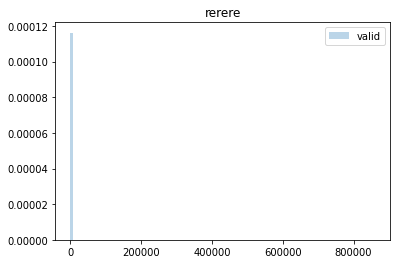

In [49]:
plt.hist(valid['caseData_life_BMI'], bins=100, density=True, alpha=0.3)
#plt.hist(test['caseData_life_BMI'], bins=100, density=True, alpha=0.3)
plt.legend(['valid', 'test'])
plt.title("rerere")
plt.show()


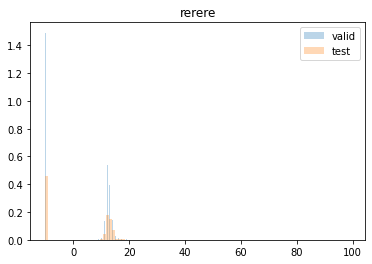

In [50]:
plt.hist(valid['caseData_life_BLOOD_PRESSURE_SYSTOLIC'], bins=100, density=True, alpha=0.3)
plt.hist(test['caseData_life_BLOOD_PRESSURE_SYSTOLIC'], bins=100, density=True, alpha=0.3)
plt.legend(['valid', 'test'])
plt.title("rerere")
plt.show()

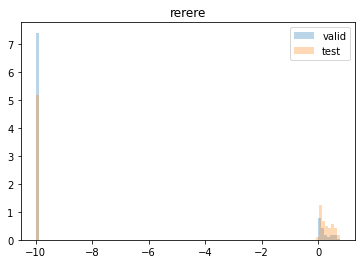

In [51]:
plt.hist(valid['concat_question_sup_1years_nlp_te_ref'], bins=100, density=True, alpha=0.3)
plt.hist(test['concat_question_sup_1years_nlp_te_ref'], bins=100, density=True, alpha=0.3)
plt.legend(['valid', 'test'])
plt.title("rerere")
plt.show()
